<a href="https://colab.research.google.com/github/sanmeshh/Synapse_LP/blob/week9/Sanmesh_NLP_Week_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SYNAPSE 2024-25 NLP Task 4**

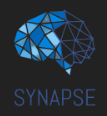






We have been exploring various Deep Learning techniques till now, and all of them somehow or the other through their shortcomings lead us to the architecture that shaped the future of NLP - the Transformer Model. Going further than its predecessor models, the Transformer architecture understands context in a way that other deep learning models like LSTM's and RNN's fail to do.

In this notebook, we will attempt to build a Transformer from scratch, particulary focusing on the Self Attention layer. A few things to note before we start:

1) This is not the **complete** and **latest** understanding of the Transformer architecture, implementing that is beyond the scope of any of us in this college as of now. This is an earlier iteration of the Attention Layer but is very much similar in its key concepts.

2) You might notice that not too many cells are given for you to complete in the Self Attention. This task is as much of understanding what is occuring in that code as it is a challenge to fill the blank sections of the code so that you don't feel overwhelmed but understand ki chal kya raha hai.

3) Don't fret if you feel overwhelmed by this, it IS difficult. Take your time, read up on resources and mainly focus on learning rather than just finishing off the task. Ok rant over

To get an idea of what we want to do and how we plan to get there, check these videos out: (StatQuest ftw):

Seq2Seq enc-dec neural networks - https://youtu.be/L8HKweZIOmg?si=lEqJj5RNRvuaOf-e

Attention in neural networks - https://youtu.be/PSs6nxngL6k?si=1NjFu2lyUhkVoIRW

Reviews.csv link download - https://drive.google.com/file/d/1T558yfJNALPogaILkbAvYO7C_P3qZEAT/view?usp=sharing

### Importing all the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Attention, Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.python.keras import backend as K
import gc
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Global Variables

These variables control key aspects of a language model for tasks like summarizing text. They set limits on input and output lengths (`max_len_text` and `max_len_summary`), determine how many times the model learns from the data (`epochs`), and specify the amount of data used (`number_of_datapoints`). The line `logger = tf.get_logger()` sets up a way to track the model's progress as it learns.

In [4]:
max_len_text=80
max_len_summary=10
epochs=10 ### PREFERABLY 50 must be done; for testing purposes use 10
number_of_datapoints=100000

logger = tf.get_logger()

Map contractions to their original phrase to make it easier to have a consistent representation of those terms and avoid mistakes in understanding context.

In [5]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
    "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as", "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

In [6]:
newString=" checking aren't ain't aren't these types of words y'all"
newString=newString.split()
newString2= [contraction_mapping[word] if word in contraction_mapping else word for word in newString]

print(newString2)

['checking', 'are not', 'is not', 'are not', 'these', 'types', 'of', 'words', 'you all']


### Utility Data Preprocessing functions

In [7]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    #removes html tags from the text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub(r'"', '',newString)#Write regex to substitute occurences of double quotes(") with a blank space('')
    newString =newString.split()
    newString= [contraction_mapping[word] if word in contraction_mapping else word for word in newString]
    newString=' '.join(newString) #Split newString into words, contract them using contraction_mapping if needed and join back into a string
    newString =re.sub(r"'s\b",' ',newString)
    newString =re.sub("[^a-zA-Z]", " ", newString)
    newString=newString.split()
    tokens = [i for i in newString if i not in set(stopwords.words("english"))] #return a list of words after removing stopwords
    long_words=[]
    for i in tokens:
      if len(i)>=3:
        long_words.append(i)

        #Append only if length of word >= 3

    return (" ".join(long_words)).strip()

In [8]:
def summary_cleaner(text):
    newString =re.sub(r'"','',text)  #Write regex to substitute occurences of double quotes(") with a blank space('')
    newString =newString.split()
    #this basically means this [(contraction_mapping[word] for word  if word in contraction_mapping else word )for word in newString]
    newString= [contraction_mapping[word] if word in contraction_mapping else word for word in newString]
    newString=' '.join(newString) #Same contraction_mapping wala code
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

### Data Preprocessing

In [9]:
data=pd.read_csv("/content/gdrive/MyDrive/Reviews.csv",nrows=number_of_datapoints)

In [10]:
data.shape
data.iloc[0,-1]


'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [11]:
#Drop duplicate values from the Text columns
data['Text']=data['Text'].drop_duplicates()
#Drop null values from the dataset
data.dropna(inplace=True)

In [12]:
from tqdm import tqdm

In [13]:
cleaned_text = []
for t in tqdm(data['Text']):
    cleaned_text.append(text_cleaner(t))



100%|██████████| 88419/88419 [12:14<00:00, 120.41it/s]


In [14]:
cleaned_text[0]

'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [15]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [16]:
cleaned_summary = []
for t in tqdm(data['Summary']):
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
#Drop tuples in the data where there is a blank value ('') in data['cleaned_summary']


100%|██████████| 88419/88419 [00:00<00:00, 153983.50it/s]


In [17]:
data['cleaned_summary']="_START_ "+data['cleaned_summary']+" _END_"#Add a '_START_ ' and ' _END_' tag at the start and end of every data point of data['cleaned_summary']

In [18]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

In [19]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

### Analysis of Sentence and Summary Length

(array([2.9500e+02, 5.5520e+03, 1.0766e+04, 9.4640e+03, 7.8100e+03,
        6.8660e+03, 6.1090e+03, 5.1920e+03, 4.3420e+03, 3.7570e+03,
        3.3260e+03, 2.7810e+03, 2.4670e+03, 2.1480e+03, 1.9010e+03,
        1.6550e+03, 1.4810e+03, 1.2940e+03, 1.0800e+03, 9.9400e+02,
        8.5200e+02, 7.3100e+02, 6.3300e+02, 6.6300e+02, 5.5000e+02,
        4.8500e+02, 4.5200e+02, 4.1900e+02, 3.5100e+02, 3.1300e+02,
        2.8500e+02, 2.4400e+02, 2.4100e+02, 2.3700e+02, 1.9700e+02,
        1.9900e+02, 1.6500e+02, 1.7300e+02, 1.2500e+02, 1.0400e+02,
        1.2100e+02, 1.0900e+02, 1.0200e+02, 1.0300e+02, 9.9000e+01,
        6.8000e+01, 6.2000e+01, 5.3000e+01, 6.6000e+01, 5.5000e+01,
        5.7000e+01, 5.0000e+01, 4.7000e+01, 5.5000e+01, 4.0000e+01,
        4.2000e+01, 2.7000e+01, 3.2000e+01, 3.3000e+01, 2.2000e+01,
        2.6000e+01, 2.4000e+01, 1.8000e+01, 1.7000e+01, 2.1000e+01,
        1.1000e+01, 2.3000e+01, 2.0000e+01, 1.1000e+01, 1.1000e+01,
        1.2000e+01, 1.8000e+01, 1.0000e+01, 1.30

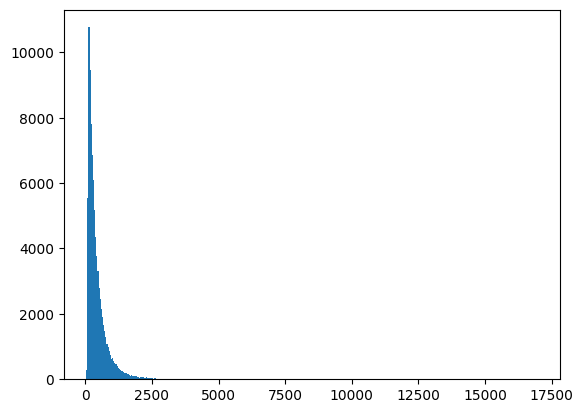

In [60]:
text_word_count = []
summary_word_count = []

for i in data['Text']:
  text_word_count.append(len(i))

plt.hist(text_word_count,bins=40)

#Make 2 histograms depicting the word count in both Text and Summary columns


In [21]:
word_count=[]

for i in data['Text'][:10]:
  print(i,end='/')



I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most./Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo"./This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch./If you are looking for the secret i

### Train-Test Split

In [22]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [23]:
#Create an instance of Tokenizer() and fit it on x_tr
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_tr)

#convert text sequences into integer sequences for x_tr and x_val
tok_xtr=tokenizer.texts_to_sequences(x_tr)
tok_xval=tokenizer.texts_to_sequences(x_val)


#Add padding as you have done in the past
tok_xtr= pad_sequences(tok_xtr,padding='post')
tok_xval=pad_sequences(tok_xval,padding='post')

words=tokenizer.word_index
x_voc_size =len(words)+1 #Number of words in vocabulary+1

In [24]:
#Create an instance of Tokenizer() and fit it on x_tr
tokenizer=Tokenizer()
tokenizer.fit_on_texts(y_tr)


#convert summary sequences into integer sequences for y_tr and y_val
tok_ytr=tokenizer.texts_to_sequences(y_tr)
tok_yval=tokenizer.texts_to_sequences(y_val)



#padding
tok_ytr= pad_sequences(tok_ytr,padding='post')
tok_yval=pad_sequences(tok_yval,padding='post')

wordz=tokenizer.word_index
y_voc_size =len(wordz)+1 #same as above

## Architecture

For the Attention Layer:
In Keras, it is easy to create a custom layer that implements attention by subclassing the Layer class. The Keras guide lists clear steps for creating a new layer via subclassing. You’ll use those guidelines here. All the weights and biases corresponding to a single layer are encapsulated by this class. You need to write the __init__ method as well as override the following methods:

build(): The Keras guide recommends adding weights in this method once the size of the inputs is known. This method “lazily” creates weights. The built-in function add_weight() can be used to add the weights and biases of the attention layer.

call(): The call() method implements the mapping of inputs to outputs. It should implement the forward pass during training.

Watch this videos to get an in-depth understanding - https://www.youtube.com/watch?v=fdhojC37_Co

https://www.youtube.com/watch?v=W2rWgXJBZhU

Read so that you understand and implement - https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/

And Read the research paper cited below!!!! :D

https://arxiv.org/abs/1706.03762 and the paper in the docstring of the function

\Don't break this code cell into smaller parts, as the tf.keras.backend.clear_session() would not be able to properly clear the session

In [25]:
tf.keras.backend.clear_session()

latent_dim = 500

# Encoder
encoder_inputs =Input(shape=(max_len_text,)) #Input layer taking input size max_len_text
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)#Make LSTM layer with input latent_dim; ensure return_sequences and return_state is True because we want the layer to backpropagate
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Add 2 more LSTM layers like above
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)#Make LSTM layer with input latent_dim; ensure return_sequences and return_state is True because we want the layer to backpropagate
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#output of one state will be the input for next state
encoder_lstm3 = LSTM(latent_dim,return_sequences=True,return_state=True)#Make LSTM layer with input latent_dim; ensure return_sequences and return_state is True because we want the layer to backpropagate
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer =Embedding(y_voc_size, latent_dim, trainable=True)#Similar to encoder layer embedding
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm =LSTM(latent_dim,return_sequences=True,return_state=True)#Similar to encoder LSTM layer
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer,self).__init__(**kwargs)

        #inherit the parent class tf.keras.layers.Layer using the super keyword and include **kwargs in the argument

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for the layer

        zeroth_index =0 # specify the zeroth tensor shape
        first_index = 1# specify the first tensor shape

        x = input_shape[zeroth_index][2]
        y = input_shape[first_index][2]

        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((y, x)),
                                   initializer='uniform',
                                   trainable=True)

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((x, x)),
                                   initializer='uniform',
                                   trainable=True)

        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((x, 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1] #Extract the final state from the states list

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s =K.dot(encoder_full_seq, self.W_a)# Dot product of encoder_full_seq and W_a

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]#Extract the final state from the states list

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


# Attention Layer
attn_layer = AttentionLayer(name='Attention_layer')#initialize object AttentionLayer and pass name parameter
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 80, 500)        │     26,026,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 80, 500),      │      2,002,000 │ embedding[0][0]        │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 80, 500),      │      2,002,000 │ lstm[0][0]             │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 500)      │      7,045,500 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 80, 500),      │      2,002,000 │ lstm_1[0][0]           │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 500),    │      2,002,000 │ embedding_1[0][0],     │
│                           │ (None, 500), (None,    │                │ lstm_2[0][1],          │
│                           │ 500)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_layer           │ [(None, None, 500),    │        500,500 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, None, 80)]      │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 1000)     │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ Attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 14091)    │     14,105,091 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,685,591 (212.42 MB)

 Trainable params: 55,685,591 (212.42 MB)

 Non-trainable params: 0 (0.00 B)

STATE YOUR UNDERSTANDING OF ATTENTION LAYER DESCRIPTIVELY :)

Write HEREEE -



In [26]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [27]:

history=model.fit([x_tr,y_tr[:,:-1]],(y_tr.reshape(y_tr.shape[0],y_tr.shape[1],1))
                  ,epochs=epochs,batch_size=512, validation_data=([x_val,y_val[:,:-1]],
                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

KeyError: 'key of type tuple not found and not a MultiIndex'

In [ ]:
gc.collect()

### Post Training Analysis & Testing

In [ ]:
#Plot loss and val_loss by extracting it from the history of the object
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training & validation loss values and accuracy

    Args:
        history: History object returned by model.fit()
    """
    # Set figure size
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Alternative version with just loss plots and more customization
def plot_loss_curves(history):
    """
    Create a detailed loss curve plot with annotations
    """
    plt.figure(figsize=(10, 6))

    # Get training and validation loss values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    # Plot the curves
    plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)

    # Find the minimum validation loss and its epoch
    min_val_loss = min(val_loss)
    min_val_epoch = val_loss.index(min_val_loss) + 1

    # Add a marker for the minimum validation loss
    plt.plot(min_val_epoch, min_val_loss, 'ro', markersize=10)
    plt.annotate(f'Min Val Loss: {min_val_loss:.4f}',
                xy=(min_val_epoch, min_val_loss),
                xytext=(10, 10),
                textcoords='offset points',
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # Customize the plot
    plt.title('Training and Validation Loss Over Time', fontsize=14, pad=20)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add background color and style
    plt.gca().set_facecolor('#f8f9fa')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage:
# For basic training and validation curves
plot_training_history(history)

# For detailed loss analysis
plot_loss_curves(history)

# If you want to access the raw values:
print("Training Loss:", history.history['loss'])
print("Validation Loss:", history.history['val_loss'])

# To get the minimum validation loss and its epoch:
min_val_loss = min(history.history['val_loss'])
min_val_epoch = history.history['val_loss'].index(min_val_loss) + 1
print(f"\nBest validation loss: {min_val_loss:.4f} at epoch {min_val_epoch}")



In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
#create a Model by specifying the inputs and the outputs (also consider h and c in output)
encoder_model =

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
#write a line similar for c

decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= #Use the decoder embedding layer you made above and pass decoder input to it

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = # create an attention layer with the help of decoder_hidden_state_input and decoder_outputs2
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary. Again, you have created this layer above, so use that
decoder_outputs2 =

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq =

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] =

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Write the code to predict the values of output_tokens, h, c based on our model

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index+1]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Write code for the Exit condition: either hit max length or find the 'end' word.
            if( ):
              stop_condition = True


        # Update the target sequence (of length 1).


        # Update internal states


    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    # write a code similar to that above, with some modifications in conditions


### Let's do some Generation

In [ ]:
i=1
print("Review:",seq2text(x_val[i]))
print("Original summary:",seq2summary(y_val[i]))
print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text))[:18])
print("\n")

End of task 4
--

### Synapse 2024-25